### Chapter 2 Exercise from:

Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélion Guéron (2017)

From: https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb

Chapter 2 – End-to-end Machine Learning project

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

This notebook contains all the sample code and solutions to the exercices in chapter 2.

Note: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

Make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Import data

In [4]:
# Import the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

## Fetch data

In [7]:
# Fetch data
fetch_housing_data()

## Load data

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
# Total bedrooms has missing data- will need to account for this.
# All attributes are numeric except for ocean_proximity, which is categorical
    # Look at the value counts to get a sense of the distribution of values in 
    # this attribute
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
# Look at the descriptive statistics summary
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


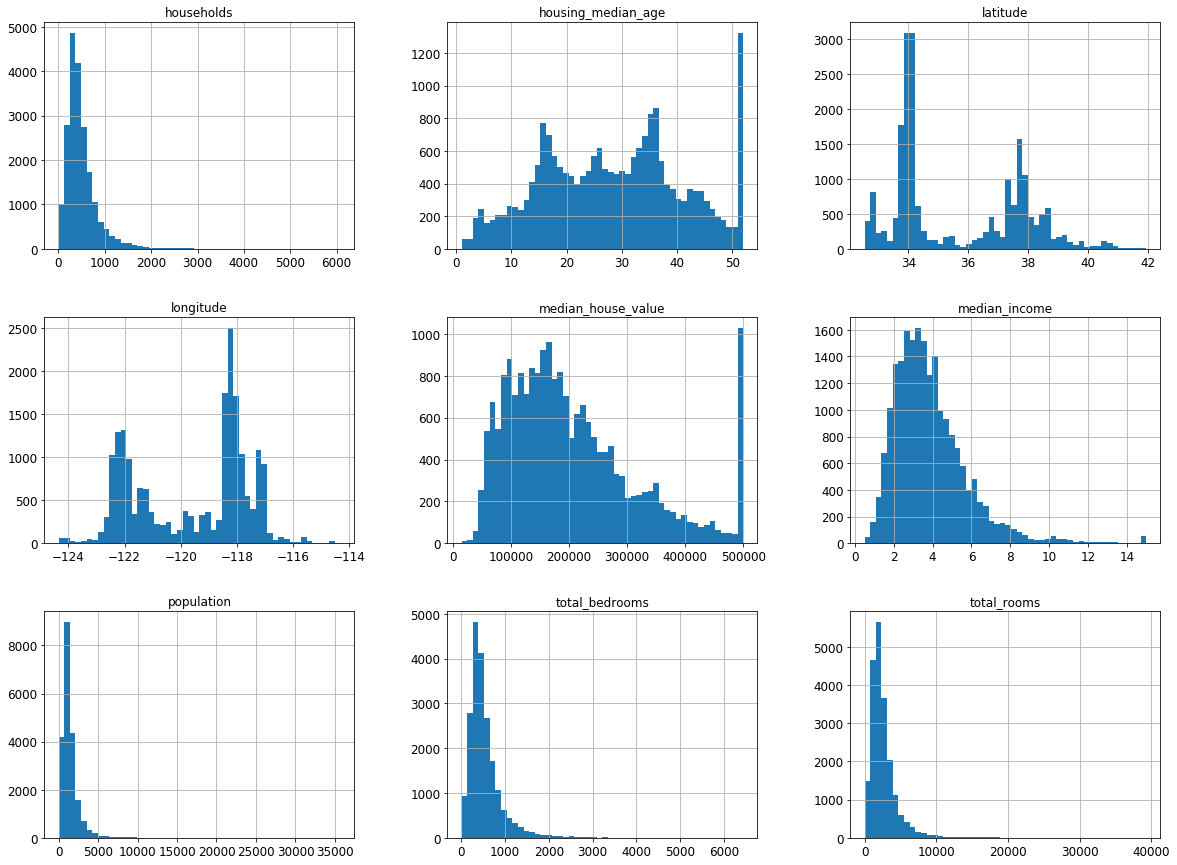

In [13]:
# On first inspection, total_rooms, total_bedrooms, population ,households are probably not normally distributed -
# - the mean and std are close in value, so that means there are probably more than a few outliers
# In terms of collinearity, total_bedrooms and total_rooms are likely correlated, although when you think of 
# the overall context this may not be the case if many of the houses are apartment buildings
# with multiple families

# Plot a histogram for all numerical attributes to get a feel for the data

%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# 1. 
# Median income seems off- it is because it isn't strictly expressed in US dollars
# it has been preprocessed: scaled and capped at 15 (15.0001) for higher median incomes,
# and 0.5 (0.49999) for lower median incomes

# Median housing age also seems off (the max is 50 and min is 1). It has also been capped.
# Median housing value is also off- we know that properties are valued at > 500K in the 
# region- it has been capped. This is potentially a big problem because is it the TARGET 
# VALUE and the algorithm may learn that houses never exceed 500K.

# If you don't need predictions to be precise over 500K, then this is not a problem.
# If you DO need precision > 500L then this IS a problem.
# You can either get the data for the houses > 500K that were capped.
# OR
# Remove those districts from the training set and test set.

# 2. 
# The attributes have very different scales in many cases.
# Feature scaling will be necessary.

# 3.
# Many of the attributes' distributions are "tail-heavy"- with tails that extend much 
# farther to the right of the median than to the left of the median.
# This can make it more difficult for some ML algorithms to detect patterns so data will
# need to be transformed to be more normally-distributed.

## Create a Test Set and set aside from Training Set
### Not using validation set because not enough data

In [28]:
# By doing this before you do more EDA (since the data are already clean) you won't choose
# an ML algorithm based on your brain picking up on one or two patterns that could distract
# from other patterns an algorithm could pick up on and also it could bias your 
# algorithm choice

# Use 20% of the dataset as the Test Set

import numpy as np

# Function to shuffle data and split training and test sets
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [21]:
# to make this notebook's output identical at every run
np.random.seed(42) # #random.seed(42) ISN'T USUALLY 42 for any special reason
# already did this at the top of the notebook,
# but just keeping it here as a reminder
# if you use new data this will "break"

# to solve this- so it doesn't break, you can use each instance's 
# identifier to decide whether or not it should go in the test set.
# # By computing a hash of each instance's identifier and keep only the lasy byte of the
# has and put the instance in the test set if the value is lower or equal to 51 (about 20% 
# of 256(? why 256)- this will ensure that the test set remains consistent across multiple
# runs, even if you refresh the dataset
# The new test set will then contain 20% of the new instances but will not contain any 
# instance that was previously in the training set.

# implementation:







In [29]:
train_set, test_set = split_train_test(housing, 0.2)

print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


In [47]:
from zlib import crc32

# didn't use this one
#def test_set_check(identifier, test_ratio):
 #   return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [51]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [52]:
# There is no identifier column in the housing dataset though, so you need to use the 
# row index as ID
 
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [53]:
# if you do this and use the row index as unique identifier you need to make sure 
# that new data gets appended to the end of the datasey and that no row ever gets deleted.
# If this isn't possible you can try to use the most stable features to build a unique 
# identifier- in this dataset it is latitude and longitude, so you can combine them into
# an ID this way:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [54]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


## Using Scikit-Learn's train-test-split:

In [55]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [56]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


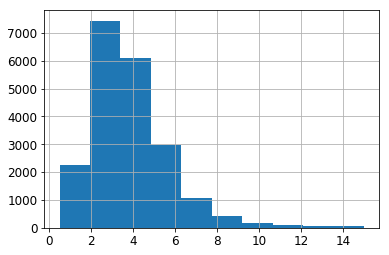

In [59]:
housing["median_income"].hist()

In [57]:
# Stratified sampling- need to make sure the training and 
# test sets represent the actual population (and the whole dataset does too)

# Since median income is a very important attribute to predict median housing prices (info.
# told from "execs." in exercise), you will want to ensure that the test set is representative 
# of all the categories of incomes in the whole dataset.
# Since the median income is a continuous numerical attribute you will first need to create 
# an income category attribute.
# most median incomes are clustered around 20K, some go way beyond 60K, need a sufficient
# number of instances in each stratum otherwise the importance of each stratum may
# be biased.
# so , you can't have too many strata and each should be large enough.

In [58]:
# Create an income category attribute by dividing the median income by 1.5 (to limit
# the number of income categories), and round up using ceil (to have discrete categories), 
# and then mering all the categories greater than 5 into category 5:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [61]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

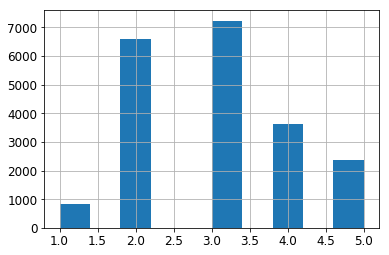

In [60]:
housing["income_cat"].hist()

In [63]:
# Now you can do stratified sampling based on the income category- do this by using
# ScikitLearn's StratifiedShuffleSplit Class:

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [64]:
# see if this worked as expected by looking at the income category proportions in the full
# housing dataset

housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [65]:
# compare to:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [66]:
# Compare proportions between housing data set (original), dataset using 
# stratified sampling, and data set using random sampling:

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [67]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [ ]:
# The proportions of the original and stratified data sets are very similar, while 
# the proportions for the randomly sampled data set are more different (skewed).

In [68]:
# Now need to remove the income_cat attribute so the data is back to its original state.

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


# EDA to gain insights into the data set

In [69]:
# First make sure you are only exploring the training set
# If the training set is very large you can take a sample of it to perform EDA on to
# so that EDA is not computational-costly. This data set is small, so no need to do so.

# Create a copy so that you do not risk altering the training set:

housing = strat_train_set.copy()

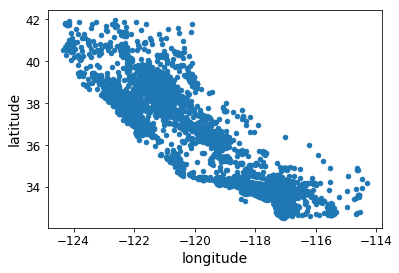

In [70]:
# Visualize the geographic data to create a scatterplot of the districts

housing.plot(kind="scatter", x="longitude", y="latitude")

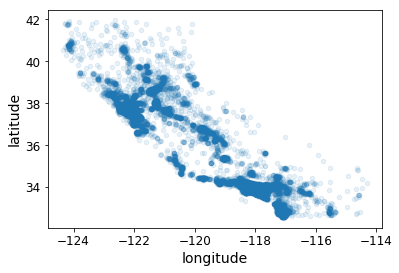

In [71]:
# Good, it looks like California!
# Set the alpha so that you can see individual data points a bit better and get a sense of 
# the density of the data points to better see how the data are geographically distributed.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

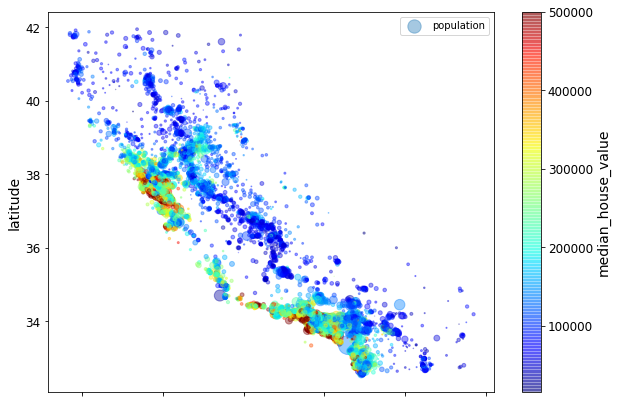

In [72]:
# Housing Prices

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

# The argument sharex=False fixes a display bug (the x-axis values and legend were not 
# displayed).
# This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611).

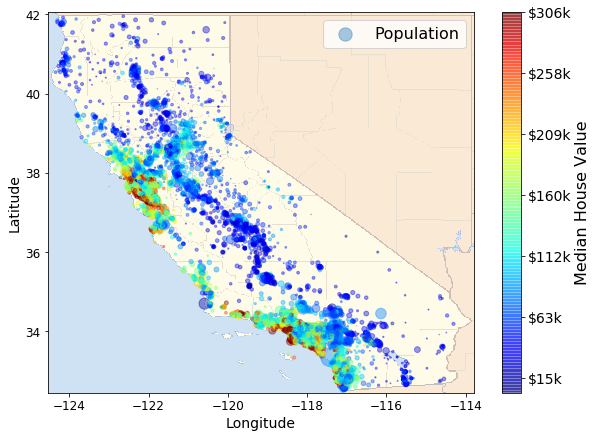

In [77]:
# add a map background
import matplotlib.image as mpimg
california_img=mpimg.imread('california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
#save_fig("california_housing_prices_plot")
plt.show()

The scatterplot above uses radius size to represent each district's population ("s=housing["population"]/100") and color to represent median house value (c=""median_house_value") using the jet cmap (predefined color map), for which higher prices are red and lower prices are blue.

You can see from this graph that housing prices are very much related to location, and also related to populaiton density. It also demonstrates that the correlation between housing price and location is much stronger than the relationship between housing price and individual district population size. District locations near the coast (ocean) are the most expensive.

It could be useful to:
Use a clustering algorithm to detect the main clusters and then add new features that represent proximity to cluster centers.
Create an attribute representing proximity to the ocean/coast, but this may breakdown as latitude increases, since the Northern districts along the coast all have lower (blue) median house values.

## Identify Correlations

Small dataset, so it is easy to computer the standart correlation coefficient (A.K.A. Pearson's r) between every pair of attributes.

In [73]:
# Standard correlation coefficient (Pearson's r) between attribute pairs:
corr_matrix = housing.corr()

In [74]:
# How does each attribute correlate with median housing value?

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

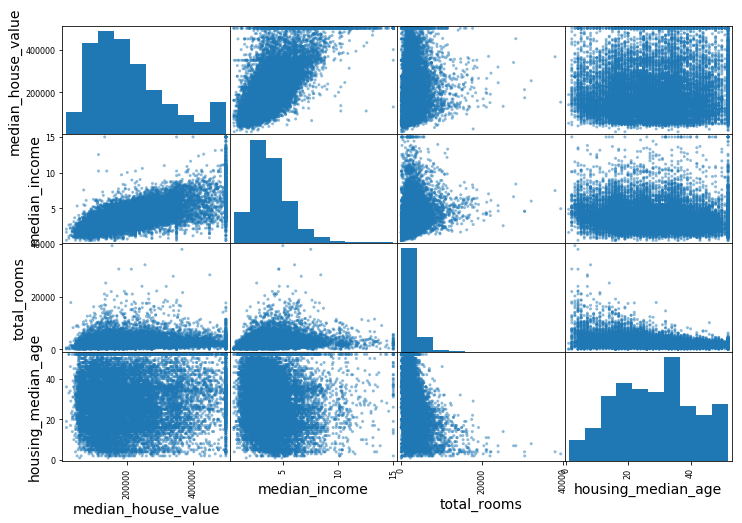

In [80]:
# Scatter matrices of correlations that seem most correlated with median housing prices 
# (because if you did all of them you'd have 121 plots)
# the diagonal plots are histograms of each attribute and not correlations
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show() #if you don't use plt.show() you get all that leading text before the plots

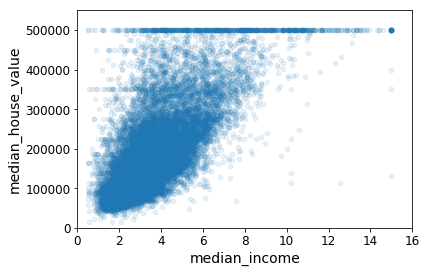

In [82]:
# Median income has the strongest correlation, so it is the most promising attribute- zoom in on this one

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

In [ ]:
# This plot shows that the max median house value has data points at all income levels, but they are most dense 
# in the middle (3-11) and at the right (16). This must be because of the preprocessing of the housing prices.
# You can see a horizontal line arounf 450,000 and 350,000 and at 500,000 and maybe one arond 380,000.
# These trends in the data or "quirks" might be reproduced if the algorithm learns them so it might be good to
# remove these corresponding districts.
# correlation is very strong, there is an upward trend, the data points are not too dispersed.

## Featuring Engineering by Combining Attributes

In [83]:
# Number of rooms in a district isn't going to be helpful unless you know how many rooms per household.
# Number of bedrooms is not very helpful unless you know how it relates to the number of rooms in the house.
# The population per household could be valuable as well.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [84]:
# Get correlations with median_house_value for these new features
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [ ]:
# The rooms per household is more strongly correlated with median house value than total rooms and also total
# rooms (rooms in a district).
# bedrooms per room is negatively correlated- houses with lower bedroom/room ratio tend to have higher median house 
# valued


# Prepare Data for Machine Learning

In [85]:
# Rever to a clean training set by copying the original again
# separate the predictors and labels bc we don't want to necessarily apply the same transformations 
# to the predictors that we apply to the target values (drop() creates a copy of the data and does not affect 
# strat_train_set).

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [86]:
# Need to deal with missing features in total_bedrooms
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
# Options: List-wise deletion, remove the attribute, impute
# don't want to remove the attribute because it is useful in the bedrooms/room, don't want to use list-wise
# deletion because there isn't that much data overall, so use imputation.
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median() # option 3
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [87]:
# use Scikit-Learn to impute
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [88]:
# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [89]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [90]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [91]:
# Check that this is the same as manually computing the median of each attribute:

housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
# Need to save the imputed median values because you will need to impute them for the test set later
# because you can't be sure that new data won't have missing values, it is better to apply imputer to all
# attributes so that any new data with missing values in other attributes will also get imputed with the median

In [92]:
# Now use "trained" imputer to transform the training set by replacing missing values with the learned medians
X = imputer.transform(housing_num)

In [93]:
# The result will be a numPy array
# Put it back into a Pandas dataframe:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [94]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [95]:
imputer.strategy

'median'

In [96]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Text and Categorical Attributes

In [ ]:
# Left out ocean_proximity because it is categorical and thus cannot compute its median.
# Convert text labels to numbers using Scikit-Learns LabelEncoder

In [97]:
# Preprocess the categorical input feature, ocean_proximity:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [98]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [99]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [100]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [101]:
# However, this won't work very well because the algorithm will assume 1 is more similar to 2 than it is to 4
# But it is a categorical value so it doesn't work this way. To deal with this use one-hot encoding so all are 
# 1s and zeros
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [102]:
# By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by 
# calling the toarray() method:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [103]:
# Alternatively, you can set sparse=False when creating the OneHotEncoder:

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [104]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [105]:
# You can do both steps (from text to integers and then from integers to one-hot vectors) in one step by using
# the LabelBinaries class:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot
# This returns a dense NumPy array by default, you can return a sparse matrix by passing sparse_output=True to
# the LabelBinarizer constructor

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [106]:
# Create a custom transformer to add extra attributes:

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [111]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


# Feature Scaling

In [112]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


Most Machine Learning algorithms do not perform well if the data (different features) are on different scales.
This data set has features with a wide range of scales! (e.g., median income range is 0-15, while total rooms ranges from 6 to 39,320.
Therefore you must apply transformations so the data is all on the same scale*.

Two common ways to scale data:

1. Min-Max Scaling (AKA normalization): Rescale data so values range from 0 to 1. (subtract the min value and divide by max-min- or use SciKit-Learn's transformer MinMaxScaler).

2. Standardization: Subtracts the mean value (standardized values always have zero mean) and divides by the variance so the resulting distribution has unit variance. Values are not bound to a specific range like in Min-Max Scaling. As a result, standardization can be a problem for some algorithms like neural networks, which usually expect all input values to range from 0 to 1. The benefit of standardization, however, is that it is* much less affected than outliers*. Sci-Kit Learn's StandardScaler transformer can be used to Standardize the data.

* Scaling Target values is generally not required.

All transformations including Feature Scaling should be fit to the training data ONLY at first, not the full dataset (including the test set).

In [113]:
# Build a pipeline for preprocessing the numerical attributes:
# All but the last estimator must be transformers.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [114]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Warning: earlier versions of the book applied different transformations to different columns using a solution based on a DataFrameSelector transformer and a FeatureUnion (see below). It is now preferable to use the ColumnTransformer class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from future_encoders.py:

In [115]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [116]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Run the whole pipeline:
housing_prepared = full_pipeline.fit_transform(housing)

In [117]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [118]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

In [119]:
# Train a linear regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [120]:
# Try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [121]:
# Compare against the actual values:

print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [123]:
# The predictions do not seem that accurate.
# Measure this regression model's RMSE on the whole training set 
# using Sci-Kit Learn's mean_squared_error function:

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [124]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

This RMSE shows that the prediction error is not good- it is $68,628 and the housing values range between $120-265K for the most part, so an error of ~ $70K is way too large. In other words, the model is *underfitting* the training data.

The MAE also is not good, although a bit better.

What does this mean? It can mean that either the features don't provide enough information to make good predictions, or the model isn't powerful enough to make good predictions.

The main ways to fix underfitting are to make a more powerful (complex) model, feed the training algorithm with more useful features, or to reduce constraints on the model. This model hasn't been regularized, so there are already no constraints on the model, meaning that you can't reduce constraints on the model because there are none. One option is to try and add more features (e.g. the log of the population), but here we first try to use a more complex model:

Train a DecisionTreeRegressor. This model is able to find complex nonlinear relationships in the data.

In [125]:
# DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [126]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The RMSE for the DecisionTreeRegressor is 0. 
It is very unlikely that this model perfectly predicts housing prices and will also perform well on the test set.
It is more likely that the model is *overfitting* the training data.
How can you be sure?
You still should not touch the test set yet because you are not confident about the model.
You can use part of the training set for training and part for validation.

# Better Evaluation Using Cross-Validation

Use train-test-split to split the training set into a training and validation set, then train model against the smaller training set and test it using the validation set.

You can do this by hand, or better yet, use K-Fold cross-validation.

K-Fold Cross-Validation randomly splits the training set into 10 distinct subsets ('folds'), trains and evaluates the Decision Tree model 10 times, each time picking a different fold for evaluation and training on the other 9 folds. The result will be an array containing the 10 evaluation scores.

# Fine-tune your model

In [127]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [128]:
# Decision Tree Scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [130]:
# Linear Scores
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983475


Note: We specify n_estimators=10 to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

You can see that the Decision Tree is overfitting so much that it is performing worse than the Linear Regression model did.

In [131]:
# Cross-Validation allows you to get an estimate of the model's performance and a measure of how precise 
# the estimate is (its standard deviation).

# Try another model- Random Forest:

# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [132]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [133]:
# Looks like RF is performing much better. Use cross-validation to evaluate:

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


In [134]:
# Okay, it is performing better, but not that much better, and the score on the training set is still much
# lower than it is on the cross-validation sets, so it is still over-fitting the training set.

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

Solutions for overfitting are:
1. Constraining the model (regularizing)
2. Simplify the model
3. Get a lot more training data

But before spending too much time tweaking the model you should try out other models from other categories of ML like SVM, maybe SVM with different kernels, neural networks, etc. Goal: Shortlist 2-5 possible models to try.

In [135]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [136]:
# Use Grid Search, which searches for the best combination of hyperparameter values.

# Using Grid Search to look for the best combination of hyperparameter values for the RandomForestRegressor:

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
# The default is refit=True. If refit=True then once it finds the best estimator using cross-validation 
# it will retrain it on the whole training set.

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [137]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [138]:
# Get the best estimator directly:

grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Look at the score of each hyperparameter combination tested during the grid search:

In [139]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [140]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061434,0.005851,0.004436,0.001164,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.257872,0.049988,0.016590,0.005138,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.622556,0.133007,0.041684,0.015990,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.102028,0.006229,0.004341,0.000627,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.343438,0.067968,0.014064,0.004016,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.041476,0.161941,0.046207,0.023201,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.134457,0.008204,0.004360,0.000624,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.440515,0.024524,0.011192,0.001360,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.795401,0.250419,0.042645,0.011725,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.176260,0.013314,0.004214,0.000543,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


When you don't have many combinations of attributes Grid Search is good, but when you do, use RandomizedSearchCV instead. It works similarly, but instead of trying all possible combinations it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

There are two main benefits to this approach:

1. This approach will explore X # of different values  (X = the number of iterations you set it to) for each hyperparameter instead of just a few values per hyperparamter as with the grid search approach.
2. You have more control over the computing budget you allocate to hyperparameter search by setting the number of iterations.

In [141]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1138bdfd0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x114717630>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [142]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


## Ensemble Methods

You can try and combine models that perform best. The group ("ensemble") will often perform better than the best individual model on its own (like RFs usually perform better than an individual Decision Tree), especially if the models make different types of errors.

## Analyze the Best Models and Their Errors

Inspect the best models to gain insight into the problem.

In [143]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [144]:
# Display the importance scores next to their corresponding attribute names:

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

You can now try dropping some of the less useful features, e.g. all but one of the 'ocean proximity' categories.

Also should look at the specific errors the system makes, try to understand why it makes them and figure out how to fix the problem (e.g., adding extra features, removing uninformaitve features, cleaning up outliers, etc.)

# Evaluate System on the Test Set

In [145]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [146]:
final_rmse

47730.22690385927

We can compute a 95% confidence interval for the test RMSE:

In [147]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

In [148]:
# Can compute the interval manually like this:

tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

In [149]:
# Alternatively, we could use a z-scores rather than t-scores:

zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# Exercises

In [153]:
# Try a SVM regressor with various hyperparameters:
# kernel="linear" with various values for the C hyperparameter (Penalty parameter C of the error term.)
# kernel= "rbf" with various values for the C and gamma hyperparameters
# How does the best SVR predictor perform?

from sklearn.svm import SVR
# C default is 1.0, with the default, the output RMSE is $111,094.6380539982
# Try C=0.5, this will increase the margin between the hyperplane and the extreme instances of each class
svm_reg = SVR(kernel="linear", C=10)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

81933.17308297305

In [ ]:
# C = 1.0 returns RMSE of:$111,094.6380539982
# C = 0.5 returns a higher RMSE: $114783.24481875032 - the predictions are poorer
# C = 10 returns RMSE of $81933.17308297305, but will this poorly generalize to new data?

### About C parameter:
The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable.

In a SVM you are searching for two things: a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. The problem is that you will not always be able to get both things. The c parameter determines how great your desire is for the latter. I have drawn a small example below to illustrate this. To the left you have a low c which gives you a pretty large minimum margin (purple). However, this requires that we neglect the blue circle outlier that we have failed to classify correct. On the right you have a high c. Now you will not neglect the outlier and thus end up with a much smaller margin.

#### Low C = larger margin between hyperplane and extreme class instances
#### Higher C = smaller margin between hyperplane and extreme class instance

Depending on your data set, changing c may or may not produce a different hyperplane. If it does produce a different hyperplane, that does not imply that your classifier will output different classes for the particular data you have used it to classify. Weka is a good tool for visualizing data and playing around with different settings for an SVM. It may help you get a better idea of how your data look and why changing the c value does not change the classification error. In general, having few training instances and many attributes make it easier to make a linear separation of the data. Also that fact that you are evaluating on your training data and not new unseen data makes separation easier.


C is essentially a regularisation parameter, which controls the trade-off between achieving a low error on the training data and minimising the norm of the weights. It is analageous to the ridge parameter in ridge regression (in fact in practice there is little difference in performance or theory between linear SVMs and ridge regression, so I generally use the latter - or kernel ridge regression if there are more attributes than observations).

Tuning C correctly is a vital step in best practice in the use of SVMs, as structural risk minimisation (the key principle behind the basic approach) is party implemented via the tuning of C. The parameter C enforces an upper bound on the norm of the weights, which means that there is a nested set of hypothesis classes indexed by C. As we increase C, we increase the complexity of the hypothesis class (if we increase C slightly, we can still form all of the linear models that we could before and also some that we couldn't before we increased the upper bound on the allowable norm of the weights). So as well as implementing SRM via maximum margin classification, it is also implemented by the limiting the complexity of the hypothesis class via controlling C.

Sadly the theory for determining how to set C is not very well developed at the moment, so most people tend to use cross-validation (if they do anything).

https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel


#### A good way to estimate the better C to be used is to perform a grid search before the final training.

In [168]:
# Use grid search to estimate best C value

# Use Grid Search, which searches for the best combination of hyperparameter values.

# Using Grid Search to look for the best combination of hyperparameter values for the RandomForestRegressor:

from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

# "verbose" - controls the verbosity: the higher, the more messages.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 19.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 31.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Should work now - but haven't run it because of computing time at the moment
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVR

#def svr_param_selection(X, y, nfolds):
 #   Cs = [1, 10, 100, 1000]
  #  gammas = [1, 10, 100, 1000]
    
   # param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
      #               'C': [1, 10, 100, 1000]},
     #             {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    #grid_search = GridSearchCV(SVR(), param_grid, cv=nfolds, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
    #grid_search.fit(X, y)
    #grid_search.best_params_
    #return grid_search.best_params_


#svr_param_selection(housing_prepared, housing_labels, 5)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [169]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

In [170]:
# That's much worse than the RandomForestRegressor.
# Check the best hyperparameters found:

grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of C is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for C (removing the smallest values), because it is likely that higher values of C will be better.

### 2. Try replacing GridSearchCV with RandomizedSearchCV.

In [218]:
# Replace GridSearchCV with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

# "verbose" - controls the verbosity: the higher you set it, the more messages.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 22.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 34.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x114ef04a8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x114ef09e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [219]:
# The best model achieves the following score (evaluated using 5-fold cross validation):

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

This result is much closer to the performance of the RandomForestRegressor (but not quite there yet). Let's check the best hyperparameters found:

In [220]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Now look at the exponential distribution we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

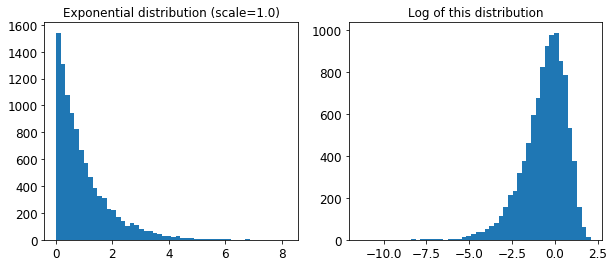

In [221]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

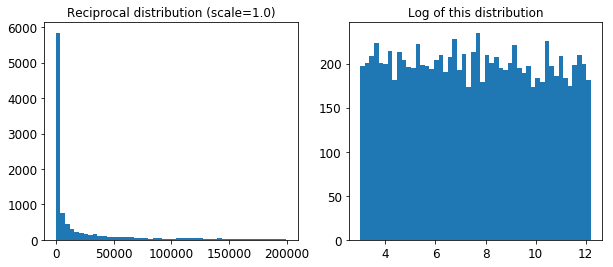

In [222]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

### 3. Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [223]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a RandomForestRegressor). You may be tempted to compute them directly in the TopFeatureSelector's fit() method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).


In [224]:
# Define the number of top features we want to keep:
k = 5

In [225]:
# Look for the indices of the top k features:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [226]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [227]:
# Double check that these are indeed the top k features:

sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Now create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [229]:
# Uses full_pipeline you defined earlier

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [230]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [231]:
# Look at the features of the first 3 instances:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [232]:
# Double-check that these are the top k features:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!

### 4. Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [233]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [234]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

### Try the full pipeline on a few instances:

In [235]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best RandomForestRegressor that we found earlier, rather than the best SVR.

### Try full pipeline with RF instead of SVR

In [190]:
# Use rf instead of SVR

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11cbbe048>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13890c128>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [191]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [192]:
# Best K- feature selection:

# Uses full_pipeline you defined earlier
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [193]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [194]:
# Look at the features of the first 3 instances:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [195]:
# Double-check that these are the top k features:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [199]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('forest_reg', RandomForestRegressor(**rnd_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos...tors=180, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False))])

### Try the full pipeline on a few instances:

In [200]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [270426.68333333 333472.23333333 215350.55555556  50392.77777778]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


# Much better



### 5. Question: Automatically explore some preparation options using GridSearchCV.

In [236]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 15.1min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 31.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [237]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

Best imputer strategy = most_frequent

Almost all features are useful (15/16). The last one (ISLAND) just adds some noise.